[Ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) is a classification method for categories on an ordinal scale -- e.g. [1, 2, 3, 4, 5] or [G, PG, PG-13, R].  This notebook implements ordinal regression using the method of [Frank and Hal 2001](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf), which transforms a k-multiclass classifier into k-1 binary classifiers (each of which predicts whether a data point is above a threshold in the ordinal scale -- e.g., whether a movie is "higher" than PG).  This method can be used with any binary classification method that outputs probabilities; here L2-regularizaed binary logistic regression is used.

This notebook trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

In [10]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            
            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y



In [13]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape

        
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model
        
    def test(self):
        self.test_preds = []
        self.test_actual = []
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]
        
        preds=np.array(preds)
        
            
        for data_point in range(len(preds[0])):
            
    
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            print(ordinal_preds, prediction)
            counts[prediction]+=1
            self.test_actual.append(self.ordinal_values.index(self.orig_testY[data_point]))
            self.test_preds.append(prediction)
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

In [14]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [15]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [16]:
def run(trainingFile, devFile, testFile, ordinal_values):


    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
    
    simple_classifier = OrdinalClassifier(ordinal_values, binary_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

In [17]:
gid=2
trainingFile = "splits/%s/train.txt" % gid
devFile = "splits/%s/dev.txt" % gid
testFile = "splits/%s/test.txt" % gid
    
# ordinal values must be in order *as strings* from smallest to largest, e.g.:
ordinal_values=["G", "PG", "PG-13", "R", "NC-17"]

#ordinal_values=["0", "1", "2"]

run(trainingFile, devFile, testFile, ordinal_values)

[0.01934292 0.13786054 0.53888723 0.2598085  0.04410081] 2
[ 0.01185623 -0.01064727  0.6567558   0.30190291  0.04013234] 2
[ 0.0226212   0.1460621   0.76812383 -0.02456255  0.08775542] 2
[0.01857329 0.05829023 0.75183423 0.14894179 0.02236045] 2
[ 0.02106771 -0.00309937  0.19296053  0.77088716  0.01818397] 3
[ 0.02086231  0.11480469  0.8463077  -0.03097514  0.04900044] 2
[ 0.02228656  0.07670757  0.89198523 -0.04514012  0.05416077] 2
[0.02231357 0.1844421  0.63135447 0.14472047 0.01716939] 2
[ 0.01555949 -0.00888218  0.58595475  0.32456155  0.08280639] 2
[0.01982086 0.3944889  0.22909925 0.33980601 0.01678497] 1
[0.01183038 0.08524695 0.6501456  0.21766243 0.03511464] 2
[0.01378647 0.100123   0.40642063 0.38732561 0.09234429] 2
[0.0166261  0.01698383 0.77267374 0.16125335 0.03246297] 2
[ 0.01571617  0.01767122  0.94863666 -0.0190051   0.03698106] 2
[ 0.02018813  0.0416766   0.92921348 -0.00497081  0.0138926 ] 2
[ 0.02303875  0.29776797  0.65347613 -0.0036904   0.02940756] 2
[0.01645301

**Part b) analysis**





In [19]:
trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

simple_classifier = OrdinalClassifier(ordinal_values, binary_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
simple_classifier.train()
simple_classifier.test()

[0.01934292 0.13786054 0.53888723 0.2598085  0.04410081] 2
[ 0.01185623 -0.01064727  0.6567558   0.30190291  0.04013234] 2
[ 0.0226212   0.1460621   0.76812383 -0.02456255  0.08775542] 2
[0.01857329 0.05829023 0.75183423 0.14894179 0.02236045] 2
[ 0.02106771 -0.00309937  0.19296053  0.77088716  0.01818397] 3
[ 0.02086231  0.11480469  0.8463077  -0.03097514  0.04900044] 2
[ 0.02228656  0.07670757  0.89198523 -0.04514012  0.05416077] 2
[0.02231357 0.1844421  0.63135447 0.14472047 0.01716939] 2
[ 0.01555949 -0.00888218  0.58595475  0.32456155  0.08280639] 2
[0.01982086 0.3944889  0.22909925 0.33980601 0.01678497] 1
[0.01183038 0.08524695 0.6501456  0.21766243 0.03511464] 2
[0.01378647 0.100123   0.40642063 0.38732561 0.09234429] 2
[0.0166261  0.01698383 0.77267374 0.16125335 0.03246297] 2
[ 0.01571617  0.01767122  0.94863666 -0.0190051   0.03698106] 2
[ 0.02018813  0.0416766   0.92921348 -0.00497081  0.0138926 ] 2
[ 0.02303875  0.29776797  0.65347613 -0.0036904   0.02940756] 2
[0.01645301

0.4723618090452261

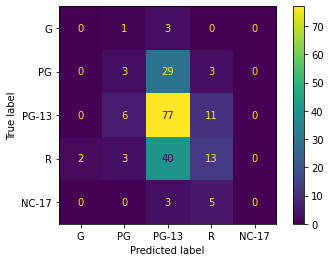

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = simple_classifier.test_preds
predictions[0] = 0
predictions[4] = 0
cm = confusion_matrix(simple_classifier.test_actual, predictions, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["G", "PG", "PG-13", "R", "NC-17"])
disp.plot()
plt.show()

## Part B)

**Confusion matrix**


When creating our confusion matrix, we ran into errors in the beginning saying that the predicted labels and the true labels were not matching. When we debugged the error to see what the issue was, we found that none of the predicted labels included “G” and “NC-17” classifications. Because these categories did not exist at all in the predictions, there was a mismatch in the number of categories and thus, the confusion matrix could not be constructed. We manually added these categories with “predictions[0] = 0” and “predictions[4] = 0”, representing the categories “G” and “NC-17”, respectively. As a result, we got the following confusion matrix:



From the above confusion matrix, we can interpret that the “PG-13” category has the largest proportion of correctly classified predicted labels, at a scale level 77. We can also interpret that the data is unbalanced as it is very concentrated in the “PG”, “PG-13”, and “R” categories. Also, these three categories are the ones that are often misclassified as one another. Specifically, “R” is misclassified as “”PG-13”, at scale level 40. ”PG” is often incorrectly classified as “PG-13”, at scale level 29. From this, we interpreted that the differentiating factors between these categories may have been hard to define for everyone’s human judgment, and that our guidelines for differentiating between these three categories should have been more clear. By better clarifying the specific conditions for each category, our team would be able to avoid our current misclassification challenge. 

<br> 

**Unbalanced Data**

As mentioned previously our categories are extremely unbalanced. While Random oversampling might help, it's possible that our guidelines should be revised in the future, knowing what we know now, to include fewer, more even, categories. The ordinal classifier might benefit from adding features with weights to the PG and R categories as they were very often incorrectly classified, though it’s important to consider bias created from them. It’s Possible that the G and NC-17 labels might be better off ignored since the hypothetical context of people looking for specific levels of horror, it’s unlikely that someone looking for something in the R range would be so put off by a story that hasn’t already been removed by the subreddit’s guidelines, and someone looking for stories in the G label would also be fine with most PG examples.

<br>

**Bias**

Our guidelines largely were adapted from the MPAA rating system, but were also informed by our (and future annotators) own opinions on what crosses certain boundaries. We were very detailed but as there are many subjective criteria such as “profane language,” as well as shortness of text selections lending themselves to concepts and events being alluded to rather than explicit , there are many areas where unintentional bias might show up. Especially since the MPAA ratings themselves aren’t free from bias related to the people and environment that created them, for example female nudity being more accepted than male nudity, it's all the more important that there are ample narrators of diverse backgrounds, and perhaps sensitivity advising on the guidelines. Certain situations, as well, might be perceived as more dangerous by certain groups, further justifying the former point.

Specifically for language, what counts as swearing, and at what point profane language might be “bad enough” to be given an R rating rather than PG-13, is very strongly influenced by the region and dialects of the people who created the guidelines and even the annotators who read each passage. Some regions might use certain swears more often than others, and so certain words might get a more taboo rating than was intended. It’s also impossible to include all swears in a list so it’s possible that slurs that are less well known especially by non-minority groups could end up classified as “for all ages.” 


<br>

**Best Performing Model**

Our best performing model was Bert, specifically where the batch size was increased. Increasing the Batch size prevents overfitting as the text passages are short. The model had .585 accuracy with .492 test accuracy.
